<a href="https://colab.research.google.com/github/thunderdog101/Machine-Learning/blob/main/TelecomChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [260]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [261]:
churn_data = pd.read_csv('https://raw.githubusercontent.com/thunderdog101/database/main/Telco-Customer-Churn.csv')

In [262]:
churn_data.head()
# churn_data.shape

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [263]:
churn_data = churn_data.replace(' ', np.nan)      # replace blank cells (one space) with NaN
churn_data.dropna(                                # remove rows with any blank cells
    axis=0,                                       # '0' to eliminate rows
    how='any',                                    # remove row if *any* cells are blank
    thresh=None,
    subset=None,
    inplace=True                                  # will not save unless set to True     
)

In [264]:
churn_data['TotalCharges'] = churn_data['TotalCharges'].astype(float).astype(int)     # change column from type object to int

In [265]:
numerical_cols = churn_data.columns[churn_data.dtypes=='int64'].tolist()
numerical_cols

['SeniorCitizen', 'tenure', 'TotalCharges']

In [266]:
churn_data.Churn.value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

# Data Pre-processing

In [267]:
numerical_cols = churn_data.columns[churn_data.dtypes=='int64'].tolist()
numerical_cols

['SeniorCitizen', 'tenure', 'TotalCharges']

In [268]:
churn_data =  churn_data.drop('customerID', 1)       

In [269]:
categorical_cols = churn_data.columns[churn_data.dtypes=='object'].tolist()
categorical_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [270]:
multi_valued_columns = churn_data[categorical_cols].nunique()[churn_data[categorical_cols].nunique() > 2].index.tolist()
multi_valued_columns

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [271]:
churn_data['PaymentMethod'].unique().shape

(4,)

In [272]:
binary_columns = churn_data[categorical_cols].nunique()[churn_data[categorical_cols].nunique() == 2].index.tolist()
binary_columns

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [273]:
# transform binary col
for column in binary_columns:
  churn_data[column] = LabelEncoder().fit_transform(churn_data[column])

In [274]:
churn_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.85,29,0
1,1,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.95,1889,0
2,1,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.85,108,1
3,1,0,0,0,45,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.30,1840,0
4,0,0,0,0,2,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.70,151,1


In [275]:
dummies_adjusted_data = pd.get_dummies(data = churn_data, columns=multi_valued_columns, drop_first=True)
dummies_adjusted_data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,2,1,1,70.70,151,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,84.80,1990,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,0,1
7039,0,0,1,1,72,1,1,103.20,7362,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,0
7040,0,0,1,1,11,0,1,29.60,346,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7041,1,1,1,0,4,1,1,74.40,306,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [276]:
std = StandardScaler()
scaled = std.fit_transform(dummies_adjusted_data[numerical_cols])
scaled = pd.DataFrame(scaled, columns=numerical_cols)
scaled

,SeniorCitizen,tenure,TotalCharges
0,-0.440327,-1.280248,-0.994363
1,-0.440327,0.064303,-0.173753
2,-0.440327,-1.239504,-0.959509
3,-0.440327,0.512486,-0.195372
4,-0.440327,-1.239504,-0.940538
...,...,...,...
7027,-0.440327,-0.343137,-0.129193
7028,-0.440327,1.612573,2.240869
7029,-0.440327,-0.872808,-0.854506
7030,2.271039,-1.158016,-0.872154


In [277]:
#dropping original values merging scaled values for numberical columns
dummies_adjusted_dataog = dummies_adjusted_data.copy()
data = dummies_adjusted_data.drop(columns = numerical_cols,axis = 1)
data = data.merge(scaled,left_index=True, right_index=True, how = "left")
# data = data.drop(['EmployeeNumber'],axis = 1) 
data

,gender,Partner,Dependents,PhoneService,PaperlessBilling,MonthlyCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen,tenure,TotalCharges
0,0,1,0,0,1,29.85,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.440327,-1.280248,-0.994363
1,1,0,0,1,0,56.95,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,-0.440327,0.064303,-0.173753
2,1,0,0,1,1,53.85,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,-0.440327,-1.239504,-0.959509
3,1,0,0,0,0,42.30,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,-0.440327,0.512486,-0.195372
4,0,0,0,1,1,70.70,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.440327,-1.239504,-0.940538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,1,1,1,1,84.80,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,0,1,NaN,NaN,NaN
7039,0,1,1,1,1,103.20,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0,1,0,0,NaN,NaN,NaN
7040,0,1,1,0,1,29.60,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,NaN,NaN,NaN
7041,1,1,0,1,1,74.40,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN


# Multicollinearity

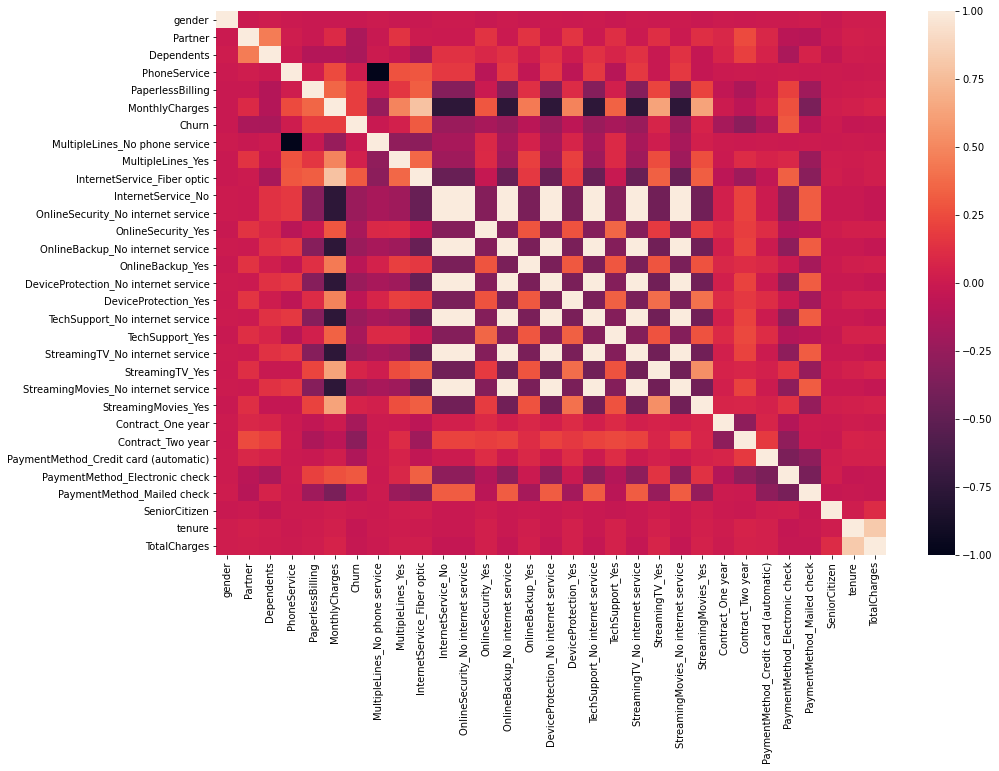

In [278]:
corr_matrix = data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix)
plt.show()

In [279]:
cols_to_melt = corr_matrix.columns
corr_matrix = corr_matrix.reset_index()

In [280]:
corr_matrix_melted = corr_matrix.melt( id_vars='index', value_vars=cols_to_melt)
corr_matrix_melted = corr_matrix_melted[corr_matrix_melted['index'] != corr_matrix_melted['variable']]
correlations_above_threshold = corr_matrix_melted[corr_matrix_melted.value.abs() > .8]
columns_to_drop = correlations_above_threshold['index'].to_list()
columns_to_drop

['MultipleLines_No phone service',
 'PhoneService',
 'OnlineSecurity_No internet service',
 'OnlineBackup_No internet service',
 'DeviceProtection_No internet service',
 'TechSupport_No internet service',
 'StreamingTV_No internet service',
 'StreamingMovies_No internet service',
 'InternetService_No',
 'OnlineBackup_No internet service',
 'DeviceProtection_No internet service',
 'TechSupport_No internet service',
 'StreamingTV_No internet service',
 'StreamingMovies_No internet service',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'DeviceProtection_No internet service',
 'TechSupport_No internet service',
 'StreamingTV_No internet service',
 'StreamingMovies_No internet service',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'OnlineBackup_No internet service',
 'TechSupport_No internet service',
 'StreamingTV_No internet service',
 'StreamingMovies_No internet service',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'OnlineBackup_No 

In [283]:
churn_data = churn_data.drop(columns=columns_to_drop, inplace=True)
# churn_data = churn_data.drop(columns_to_drop, 1)

KeyError: ignored

In [ ]:
corr_matrix = data.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix)
plt.show()

# Unbalanced data

In [ ]:
churn_data.Churn.value_counts()

In [ ]:
positive_labels = churn_data[churn_data.Churn==1]
num_positive_labels = positive_labels.shape[0]
num_positive_labels

In [ ]:
negative_labels = churn_data[churn_data.Churn==0].sample(num_positive_labels)
negative_labels.shape

In [ ]:
balanced_data = positive_labels.append(negative_labels)

# Splitting data into test splits

In [ ]:
balanced_data.head()

In [ ]:
y = balanced_data.pop('Churn')
X = balanced_data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [ ]:
X_train.head()

In [285]:
# fit a model
clf = LogisticRegression(random_state=0, penalty='l2').fit(X_train, y_train)
# predict probabilities
predictions = clf.predict_proba(X_test)[:,1]

ValueError: ignored

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
# Confusion matrix

pd.DataFrame(confusion_matrix(y_test, y_pred))

In [ ]:
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'] , margins=True)
df_confusion

In [ ]:
# calculate scores
auc = roc_auc_score(y_test, predictions)

# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, predictions)

plt.figure(figsize=(15,10))
# plot horizontal line
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
# axis labels
plt.xlabel('FPR')
plt.ylabel('TPR')
# show the legend
plt.legend(loc='lower right')
# show the plot
plt.show()

In [ ]:
feature_importance = abs(clf.coef_[0])
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

featfig = plt.figure(figsize=(10,15))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)

plt.show()